In [7]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt
import os

In [2]:
MODEL_PATH = 'best_emotion_model.keras' 
CLASS_NAMES = ['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']
IMG_SIZE = 224
FACE_CASCADE_PATH = 'haarcascade_frontalface_default.xml'

In [3]:
def load_resources():
    if not os.path.exists(MODEL_PATH):
        print(f"ERROR: Model '{MODEL_PATH}' tidak ditemukan!")
        return None, None
    if not os.path.exists(FACE_CASCADE_PATH):
        print(f"ERROR: Haarcascade '{FACE_CASCADE_PATH}' tidak ditemukan!")
        return None, None

    print("Memuat model...")
    try:
        model = tf.keras.models.load_model(MODEL_PATH)
        print("Model berhasil dimuat.")
    except Exception as e:
        print(f"Gagal memuat model: {e}")
        return None, None

    face_classifier = cv2.CascadeClassifier(FACE_CASCADE_PATH)
    if face_classifier.empty():
        print("Gagal memuat face detector.")
        return None, None

    return model, face_classifier

In [4]:
def start_recognition_photo():
    model, face_classifier = load_resources()
    if model is None or face_classifier is None:
        return

    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("Tidak dapat mengakses kamera.")
        return

    print("Mengambil foto dalam 3 detik...")
    for i in range(15):
        cap.read()
    
    ret, frame = cap.read()
    cap.release()

    if not ret or frame is None:
        print("Gagal menangkap frame gambar.")
        return

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = face_classifier.detectMultiScale(
        gray_frame, 
        scaleFactor=1.3, 
        minNeighbors=5, 
        minSize=(30, 30)
    )

    print(f"Ditemukan {len(faces)} wajah.")

    if len(faces) == 0:
        print("Wajah tidak terdeteksi.")
        plt.figure(figsize=(6, 6))
        plt.imshow(rgb_frame)
        plt.axis('off')
        plt.title("Tidak ada wajah terdeteksi")
        plt.show()
        return

    for (x, y, w, h) in faces:
        cv2.rectangle(rgb_frame, (x, y), (x + w, y + h), (0, 255, 0), 3)
        roi_face = frame[y:y + h, x:x + w]
        if roi_face.size == 0:
            continue
            
        roi_face = cv2.cvtColor(roi_face, cv2.COLOR_BGR2RGB)
        roi_face = cv2.resize(roi_face, (IMG_SIZE, IMG_SIZE))
        
        img_array = tf.keras.utils.img_to_array(roi_face)
        img_array = tf.expand_dims(img_array, 0)
        img_array = preprocess_input(img_array)

        predictions = model.predict(img_array, verbose=0)
        predicted_index = np.argmax(predictions[0])
        predicted_label = CLASS_NAMES[predicted_index]
        confidence = np.max(predictions[0]) * 100

        label_text = f"{predicted_label} ({confidence:.1f}%)"
        
        cv2.putText(rgb_frame, label_text, (x, y - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    plt.figure(figsize=(10, 8))
    plt.imshow(rgb_frame)
    plt.axis('off')
    plt.title("Hasil Deteksi Emosi")
    plt.show()

Memuat model...
Model berhasil dimuat.
Mengambil foto dalam 3 detik...
Ditemukan 0 wajah.
Wajah tidak terdeteksi.


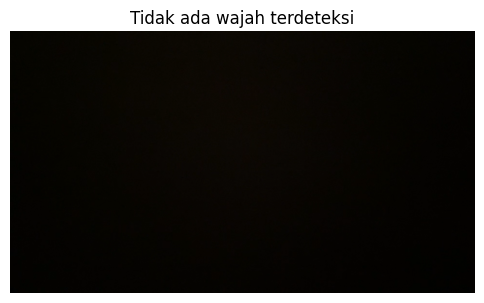

In [5]:
if __name__ == "__main__":
    start_recognition_photo()